# Getting started with `sbi`

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started.ipynb) in the `sbi` repository.

In [1]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer

In [2]:
sigma_min = 1e-2
mean_fn = lambda x_source, x_target, t: (1-t)*x_source + t * x_target
std_fn = lambda x_source, x_target, t: torch.sqrt(2*t * (1-t))


In [3]:

from torch import nn

from sbi.neural_nets.vf_estimators.flow_estimator import FlowMachtingEstimator


In [4]:
import numpy as np


class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.0):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super().__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.time_embed_dim = 100
        self.time_embed = GaussianFourierProjection(self.time_embed_dim)
        self.num_layers = 5
        self.hidden_dim = 100
        self.linear1 = nn.Linear(self.input_dim + self.condition_dim, self.hidden_dim)
        self.dense = nn.Sequential(
            nn.Linear(self.hidden_dim + self.time_embed_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.input_dim)
        )

    def forward(self, input, condition, t):

        input_and_condition = torch.cat([input, condition], dim=-1)
        h_x = self.linear1(input_and_condition)
        time_embed = self.time_embed(t)


        h = torch.cat([h_x, time_embed], dim=-1)
        out = self.dense(h)

        return out

In [5]:
times = torch.rand((100,1))
xs_source = torch.rand((100,2))
xs_target = torch.rand((100,2))
with torch.enable_grad():
    times = times.clone().requires_grad_(True)
    m_t = mean_fn(xs_source, xs_target, times)
    grad = torch.autograd.grad(m_t, times, grad_outputs=torch.ones_like(m_t), create_graph=True)[0]

In [190]:
from torch import Tensor


class OTFlowMatchingEstimator(FlowMachtingEstimator):

    def __init__(self, net, condition_shape, sigma_min=1e-5):
        super().__init__(net, condition_shape)
        self.sigma_min = sigma_min

    def mean_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return  times*xs_target

    def std_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return  (1 - (1-self.sigma_min)*times)



In [ ]:
# Variance preserving conditional flow matching
sigma = 1e-4
mean_fn = lambda x_source, x_target, t: jnp.cos(jnp.pi / 2*t)*x_source + jnp.sin(jnp.pi / 2*t)*x_target
std_fn = lambda x_source, x_target, t: jnp.array(sigma)

In [145]:

class VPFlow(FlowMachtingEstimator):


    def mean_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return torch.cos(np.pi / 2*times)*xs_source + torch.sin(np.pi / 2*times)*xs_target

    def std_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return torch.tensor([1e-5])

    def std_fn_grad(self, xs_source: Tensor, xs_target: Tensor, times: Tensor) -> Tensor:
        return torch.tensor([0.])


In [191]:
flow_estimator = OTFlowMatchingEstimator(ScoreNet(3,3), (3,))

In [192]:
flow_estimator.std_fn_grad(torch.zeros((10,2)),torch.ones((10,2)),torch.zeros((10,1))+ 1e-4)

tensor([[-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000]])

In [193]:
def build_estimator(thetas,xs):
    input_dim = thetas.shape[-1]
    condition_dim = xs.shape[-1]
    estimator = OTFlowMatchingEstimator(ScoreNet(input_dim,condition_dim), (condition_dim,))
    return estimator


In [194]:
from sbi.inference import SNPE

In [195]:
inference = SNPE(density_estimator=build_estimator, show_progress_bars=True)

In [196]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

thetas = prior.sample((10000,))
xs = simulator(thetas)

In [197]:
inference = inference.append_simulations(thetas, xs)

In [198]:
inference._summary

{'epochs_trained': [],
 'best_validation_loss': [],
 'validation_loss': [],
 'training_loss': [],
 'epoch_durations_sec': []}

In [199]:
score_net = inference.train(training_batch_size=1000,stop_after_epochs=500)

 Neural network successfully converged after 1495 epochs.

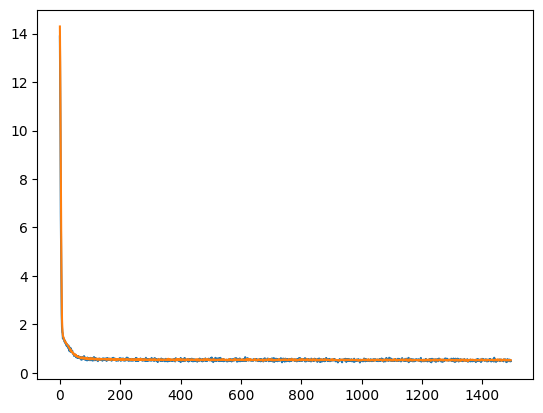

In [200]:
import matplotlib.pyplot as plt

plt.plot(inference._summary["validation_loss"])
plt.plot(inference._summary["training_loss"])

In [182]:
samples_0 = score_net.source_distribution.sample((1000,3))

In [183]:
theta_o = prior.sample((1,))
x_o = simulator(theta_o)

In [184]:
x_os = torch.repeat_interleave(x_o, 1000, dim=0)

def drift(x, t):
    return score_net(x, condition = x_os, time=t* torch.ones((1000,1)))

In [185]:
import torch


def euler(f, y0, t):
    """
    Euler's method for solving ODEs.

    Parameters:
    f : function
        Function that defines the ODE.
    y0 : torch.Tensor
        Initial condition.
    t : torch.Tensor
        1D tensor of t values where the ODE should be solved.

    Returns:
    torch.Tensor
        1D tensor of y values where the ODE has been solved.
    """
    y = torch.zeros(t.shape[0], *y0.shape, dtype=y0.dtype, device=y0.device)
    y[0] = y0

    for i in range(1, t.shape[0]):
        dt = t[i] - t[i-1]
        y[i] = y[i-1] + f(y[i-1], t[i-1]) * dt

    return y

In [186]:
samples = euler(drift, samples_0, torch.linspace(0, 1, 100))

In [187]:
from sbi.analysis import pairplot

(<Figure size 500x500 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

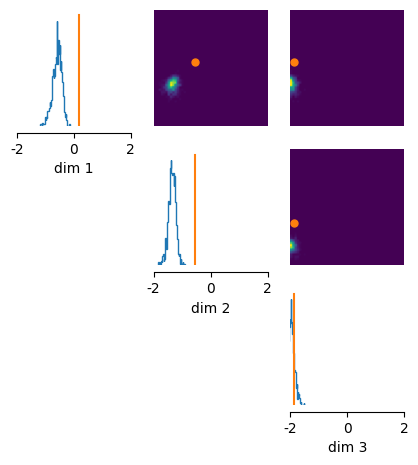

In [188]:
pairplot(samples[-1].detach(), limits=[[-2, 2], [-2, 2], [-2, 2]], points=theta_o, figsize=(5, 5))

(<Figure size 1000x1000 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

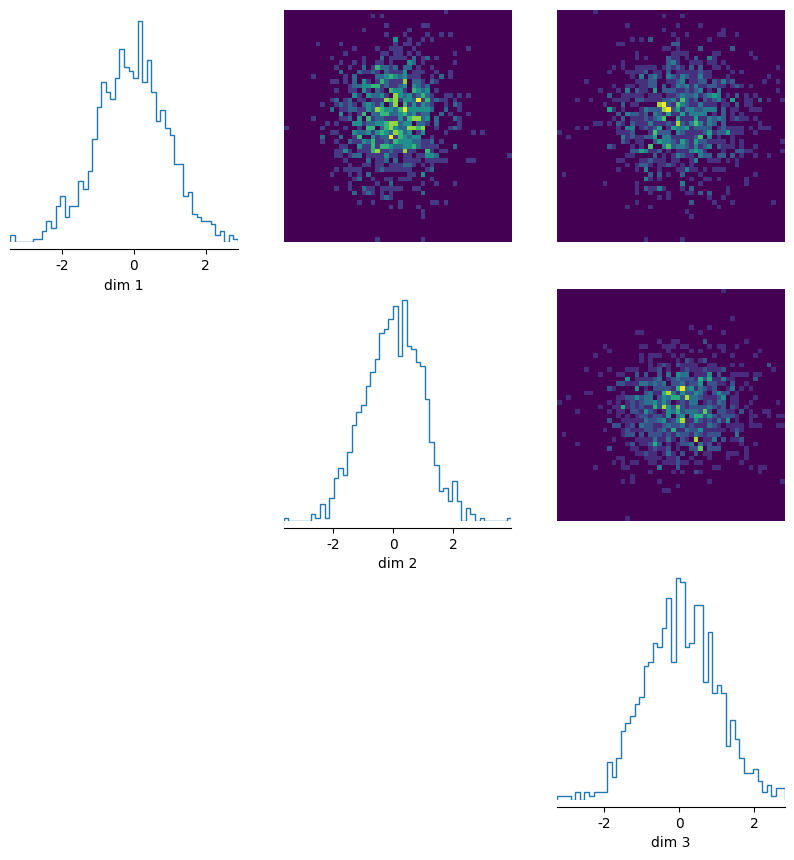

In [ ]:
from sbi.analysis import pairplot

pairplot(samples_t.detach())

## Running the inference procedure

`sbi` provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

For inference, you need to provide two ingredients:

1) a prior distribution that allows to sample parameter sets.  
2) a simulator that takes parameter sets and produces simulation outputs.

For example, we can have a 3-dimensional parameter space with a uniform prior between [-1,1] and a simple simulator that for the sake of example adds 1.0 and some Gaussian noise to the parameter set:

In [6]:
%autoreload

UsageError: Line magic function `%autoreload` not found.


In [1]:
import torch
from sbi.analysis import pairplot
from sbi import utils as utils
from sbi.inference import infer

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

`sbi` can then run inference:

In [14]:
# Other methods are "SNLE" or "SNRE".
posterior = infer(simulator, prior, method="SNLE", num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 110 epochs.

/root/sbi/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [15]:
observation = torch.randn(2,3)

In [16]:
samples = posterior.sample_batched((100,), x=observation, method="slice_np_vectorized", num_chains=1)

Start run


/root/sbi/sbi/utils/user_input_checks.py:604: UserWarning: An x with a batch size of 2 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warn_on_iid_x(num_trials=input_x_shape[0])


Running vectorized MCMC with 2 chains:   0%|          | 0/600 [00:00<?, ?it/s]

Finish run


In [21]:
samples1 = posterior.sample_batched((100,), x=observation[0], method="slice_np_vectorized", num_chains=1)

Start run


Running vectorized MCMC with 3 chains:   0%|          | 0/900 [00:00<?, ?it/s]

Finish run


Let's say we have made some observation $x$:

In [17]:
samples.shape

torch.Size([100, 2, 3])

(<Figure size 500x500 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>,
         <Axes: xlabel='dim 3'>]], dtype=object))

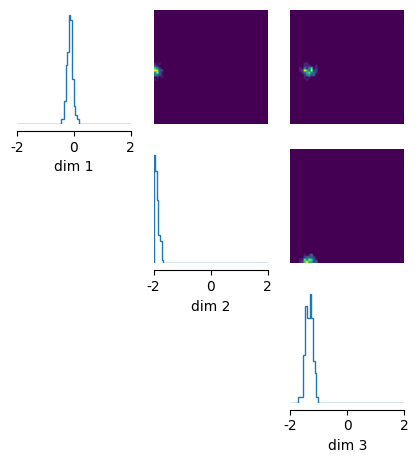

In [26]:
pairplot(samples[:,1], limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5))

(<Figure size 500x500 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>,
         <Axes: xlabel='dim 3'>]], dtype=object))

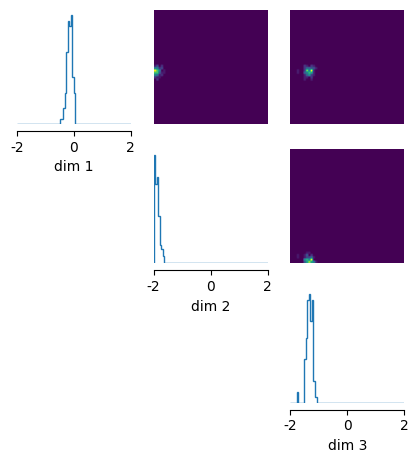

In [27]:
pairplot(samples1[:,0], limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5))

In [7]:
posterior.sample((100000,), x=torch.zeros(3)).shape

Start run


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
observation = torch.ones(3)

In [ ]:
posterior_samples = posterior.sample_batched((1000,), x=observation)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
posterior_samples.shape

torch.Size([1000, 1, 3])

In [ ]:
posterior.log_prob_batched(posterior_samples, x=observation).shape

torch.Size([1, 3])


torch.Size([1000, 1])

In [21]:
posterior.log_prob_batched(posterior_samples, x=observation).shape

torch.Size([1, 3])


torch.Size([1000, 1])

In [15]:
posterior_samples.shape

torch.Size([1000, 1, 3])

In [14]:
posterior.posterior_estimator.log_prob(posterior_samples, condition=observation)

tensor([[ 3.2115e+00],
        [ 3.3251e+00],
        [-8.1589e-01],
        [ 2.1335e+00],
        [ 3.3642e+00],
        [ 3.5596e+00],
        [ 2.5018e+00],
        [ 1.6941e+00],
        [ 2.0254e+00],
        [ 2.5706e+00],
        [-1.1574e+00],
        [ 1.7518e+00],
        [ 1.0811e+00],
        [ 2.0845e+00],
        [ 3.8704e+00],
        [ 3.3941e+00],
        [ 4.3088e-01],
        [ 3.9793e+00],
        [ 3.6628e+00],
        [ 3.4932e+00],
        [ 2.6633e+00],
        [ 2.9332e+00],
        [ 3.7385e+00],
        [ 3.4523e+00],
        [ 3.6666e+00],
        [ 3.3699e+00],
        [ 4.1876e+00],
        [ 3.6965e+00],
        [ 3.5368e+00],
        [ 2.9084e+00],
        [-3.4667e-01],
        [ 3.6774e+00],
        [ 3.5569e+00],
        [ 2.0696e+00],
        [ 2.8649e+00],
        [ 3.0434e+00],
        [-3.9730e+00],
        [ 3.5918e+00],
        [ 3.3842e+00],
        [ 3.6109e+00],
        [ 3.7828e+00],
        [ 3.5782e+00],
        [ 2.3492e+00],
        [ 1

In [1]:



# This file is part of sbi, a toolkit for simulation-based inference. sbi is licensed
# under the Apache License Version 2.0, see <https://www.apache.org/licenses/>

import torch
from torch import eye, ones, zeros

from sbi import utils as utils
from sbi.inference import (
    SNPE_C,
    DirectPosterior,
    simulate_for_sbi,
)
from sbi.simulators.linear_gaussian import (
    linear_gaussian,
    samples_true_posterior_linear_gaussian_uniform_prior,
)
from sbi.utils import RestrictionEstimator
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_simulator,
)
from sbi.inference import SNLE_A, SNPE_C, SNRE_A
from sbi.inference.posteriors import EnsemblePosterior
from sbi.simulators.linear_gaussian import (
    linear_gaussian,
    true_posterior_linear_gaussian_mvn_prior,
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from sbi.inference import SNLE_A
from torch.distributions import MultivariateNormal
    
inference_method=SNLE_A
num_trials = 5
num_dim = 2
ensemble_size = 2
x_o = zeros(num_trials, num_dim)
num_samples = 500
num_simulations = 2000
mcmc_params_accurate = dict(num_chains=20, thin=2, warmup_steps=50)

# likelihood_mean will be likelihood_shift+theta
likelihood_shift = -1.0 * ones(num_dim)
likelihood_cov = 0.3 * eye(num_dim)

prior_mean = zeros(num_dim)
prior_cov = eye(num_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)
gt_posterior = true_posterior_linear_gaussian_mvn_prior(
x_o, likelihood_shift, likelihood_cov, prior_mean, prior_cov
)
target_samples = gt_posterior.sample((num_samples,))

def simulator(theta):
    return linear_gaussian(theta, likelihood_shift, likelihood_cov)

# train ensemble components
posteriors = []
for _ in range(ensemble_size):
    theta = prior.sample((num_simulations,))
    x = simulator(theta)
    inferer = inference_method(prior)
    inferer.append_simulations(theta, x).train(
        training_batch_size=100,
        max_num_epochs=1 if inference_method == "SNPE" and num_trials > 1 else 100,
    )
    posteriors.append(inferer.build_posterior())

# create ensemble
posterior = EnsemblePosterior(posteriors)
posterior.set_default_x(x_o)

# test sampling and evaluation.
if isinstance(inferer, (SNLE_A, SNRE_A)):
    samples = posterior.sample(
        (num_samples,),
        method="slice_np_vectorized",
        **mcmc_params_accurate,
    )
else:
    samples = posterior.sample((num_samples,))
_ = posterior.potential(samples)

# Compute the c2st and assert it is near chance level of 0.5.


map_ = posterior.map(init_method=samples, show_progress_bars=False)
assert ((map_ - gt_posterior.mean) ** 2).sum() < 0.5

# Checks for log_prob()
# For the Gaussian prior, we compute the KLd between ground truth and posterior.
# This step is skipped for NLE since the probabilities are not normalised.
if isinstance(inferer, (SNPE_C, SNRE_A)):
    dkl = get_dkl_gaussian_prior(
        posterior,
        x_o[0],
        likelihood_shift,
        likelihood_cov,
        prior_mean,
        prior_cov,
        num_samples=num_samples,
    )
    max_dkl = 0.15
    assert (
        dkl < max_dkl
    ), f"D-KL={dkl} is more than 2 stds above the average performance."

# test individual log_prob and map
posterior.log_prob(samples, individually=True)

 Neural network successfully converged after 71 epochs.

/root/sbi/sbi/utils/user_input_checks.py:604: UserWarning: An x with a batch size of 5 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warn_on_iid_x(num_trials=input_x_shape[0])


Start run


Running vectorized MCMC with 20 chains:   0%|          | 0/2480 [00:00<?, ?it/s]

Finish run
torch.Size([231, 2])
Start run


Running vectorized MCMC with 20 chains:   0%|          | 0/2540 [00:00<?, ?it/s]

Finish run
torch.Size([269, 2])


(tensor([[-0.6931],
         [-0.6931]]),
 tensor([[ -7.4336,  -6.9223,  -7.8938,  -8.8298,  -7.0743,  -6.5152,  -9.2128,
           -6.5681,  -8.7400,  -6.2765,  -7.2174,  -8.4947,  -6.2702,  -7.8866,
           -6.2610,  -6.2908,  -7.3255,  -7.7226,  -6.7372,  -7.8981,  -7.1027,
           -6.8723,  -6.8812,  -7.5888,  -7.3460,  -6.9320,  -6.7316,  -6.3312,
           -6.4442,  -7.0695,  -7.4121,  -6.3988,  -7.3478,  -6.2714,  -8.2118,
           -7.3753,  -8.4640,  -6.9190,  -6.8717,  -6.8066,  -9.9928,  -7.3078,
           -8.0485,  -7.2805,  -6.7070,  -6.5855,  -6.9627,  -8.0247,  -6.5141,
           -6.4445,  -9.0908,  -7.7227,  -7.8546,  -7.4221,  -6.6174,  -6.4591,
           -6.4629,  -7.7549,  -7.1957,  -6.4203,  -6.8921,  -8.6906,  -7.3244,
           -6.6333,  -6.7162,  -6.8824,  -7.5157,  -6.7391,  -6.9752,  -8.6719,
           -8.3198,  -6.4059,  -6.4676,  -8.5537,  -8.1975,  -7.5111,  -8.7388,
           -6.2830,  -6.7911,  -6.8002,  -6.8710,  -6.5664,  -6.6077,  -6.3470

In [3]:
13*20

260

In [ ]:
samples[0].shape

torch.Size([260, 2])

 Given this observation, we can then sample from the posterior $p(\theta|x)$, evaluate its log-probability, or plot it.

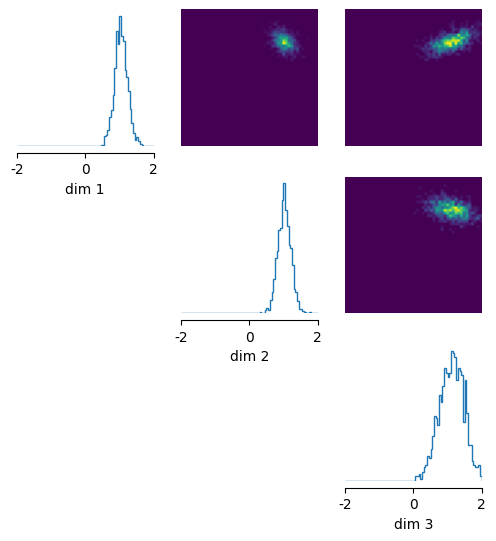

In [ ]:

samples1 = posterior_samples[:,2].detach()
_ = analysis.pairplot([samples1], limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6))

## Next steps

The single-line interface described above provides an easy entry for using `sbi`. However, on almost any real-world problem that goes beyond a simple demonstration, we strongly recommend using the [flexible interface](https://sbi-dev.github.io/sbi/tutorial/02_flexible_interface/).